In [317]:
import json
import pandas as pd
import numpy as np
import networkx as nx
import jellyfish
import os
import shutil
import subprocess
import requests
from github import Github
from git import Repo
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from zipfile import ZipFile
from filecmp import dircmp
import configparser
import h2o
import scipy as sp

## Result Gathering

In [447]:
main_df = None
directory = "Effort_Estimation_Results_3E_v2/"
for filename in os.listdir(directory):
    print(filename)
    if main_df is None:
        main_df = pd.read_csv(os.path.join(directory, filename))
        main_df['project_name'] = filename.replace('.csv', '')
    else:
        temp_df = pd.read_csv(os.path.join(directory, filename))
        temp_df['project_name'] = filename.replace('.csv', '')
        frames = [main_df, temp_df]
        main_df = pd.concat(frames)

Alluxio.csv
Assertj-core.csv
Atmosphere.csv
AxonFramework.csv
Beam.csv
Byte-buddy.csv
Camel.csv
Cas.csv
Cassandra.csv
Cxf.csv
Dbeaver.csv
Eclim.csv
Guacamole-client.csv
Hadoop.csv
Hawtio.csv
karaf.csv
Okhttp.csv
Openapi-generator.csv
Orientdb.csv
Redisson.csv
Rest-assured.csv
Spring-framework.csv
Spring-security.csv
Storm.csv
Tika.csv
Traccar.csv


In [448]:
main_df.head()

,kmean_label,time_taken_mean,time_taken_min,time_taken_max,time_taken_q10,time_taken_q20,time_taken_q25,time_taken_q30,time_taken_q40,time_taken_q50,...,actual_num_of_classes_touched_min,actual_num_of_classes_touched_max,actual_num_of_classes_touched_std,commit_line_changed,refactoring_perc,refactoring_perc_time_taken,cocomoII_time_taken,geneticP_time_taken,softwareMaintenance_time_taken,fuzzy_time_taken
0,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,2,2,NaN,8,1.000000,15.00000,4.13952,2.477916,12.48,42.435515
1,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,1,NaN,346,0.225434,1.00000,179.03424,107.076009,2229.76,519.589347
2,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,2,0.707107,35,1.000000,1.00000,18.11040,10.840124,189.60,113.234791
3,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,13,4.018895,194,0.185567,3.71134,100.38336,60.060503,1232.64,353.641141
4,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,136,50.585661,1938,0.004128,1.00000,1002.79872,597.273303,12673.28,1634.048307


In [449]:
for column in main_df:
    print(column)

kmean_label
time_taken_mean
time_taken_min
time_taken_max
time_taken_q10
time_taken_q20
time_taken_q25
time_taken_q30
time_taken_q40
time_taken_q50
time_taken_q60
time_taken_q70
time_taken_q75
time_taken_q80
time_taken_q90
sha
name
email
date
login
message
parent_sha
parent_date
time_taken
contains_refactoring
project_name
commit_compared_with
cbo_mean
cbo_min
cbo_max
cbo_std
wmc_mean
wmc_min
wmc_max
wmc_std
dit_mean
dit_min
dit_max
dit_std
rfc_mean
rfc_min
rfc_max
rfc_std
lcom_mean
lcom_min
lcom_max
lcom_std
totalMethods_mean
totalMethods_min
totalMethods_max
totalMethods_std
staticMethods_mean
staticMethods_min
staticMethods_max
staticMethods_std
publicMethods_mean
publicMethods_min
publicMethods_max
publicMethods_std
privateMethods_mean
privateMethods_min
privateMethods_max
privateMethods_std
protectedMethods_mean
protectedMethods_min
protectedMethods_max
protectedMethods_std
defaultMethods_mean
defaultMethods_min
defaultMethods_max
defaultMethods_std
abstractMethods_mean
abstractMe

In [450]:
len(main_df)

775

In [451]:
main_df['refactoring_perc_time_taken'] = main_df['refactoring_perc'] * main_df['time_taken']

In [452]:
def plotGraph(y_test,y_pred,y_test_str,y_pred_str,regressorName):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
        
    plt.figure(figsize=(15,15))
    plt.scatter(range(len(y_test)), y_test, color='blue', label=y_test_str)
    plt.scatter(range(len(y_pred)), y_pred, color='red', label=y_pred_str)
    plt.title(regressorName)
    plt.legend(loc="upper left")
    plt.show()
    return

def plotGraphandSave(y_test,y_pred,y_test_str,y_pred_str,regressorName,img_name):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
        
    plt.figure(figsize=(15,15))
    plt.scatter(range(len(y_test)), y_test, color='blue', label=y_test_str)
    plt.scatter(range(len(y_pred)), y_pred, color='red', label=y_pred_str)
    plt.title(regressorName)
    plt.legend(loc="upper left")
    plt.savefig(f'model_prediction_images/{img_name}.png')
    plt.show()
    return





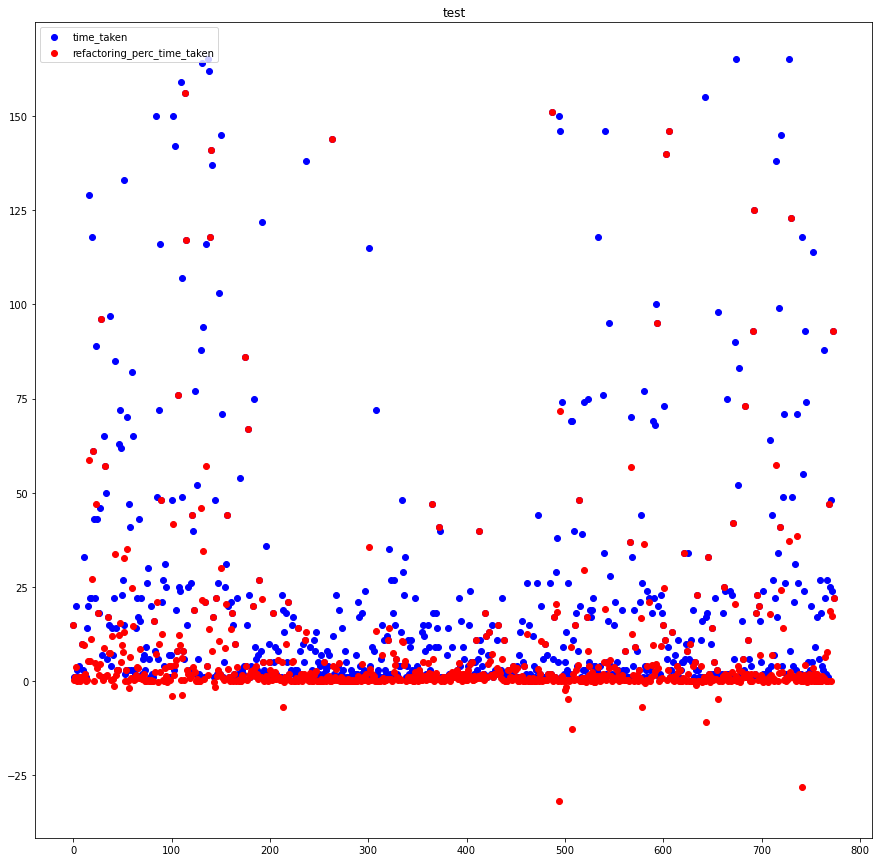

In [453]:
plotGraph(main_df['time_taken'], main_df['refactoring_perc_time_taken'],'time_taken','refactoring_perc_time_taken','test')

In [454]:
main_df = main_df[main_df['refactoring_perc_time_taken'] > 0]
main_df = main_df[main_df['refactoring_perc_time_taken'] <= 8]
#main_df = main_df[main_df['refactoring_perc_time_taken'] <= 20]

#main_df = main_df[main_df['time_taken_final'] <= 60]
#main_df = main_df[main_df['time_taken_final'] > 2]

In [455]:
main_df['refactoring_perc_time_taken'].value_counts()

1.000000    27
2.000000    23
3.000000    11
4.000000     6
5.000000     6
            ..
0.318253     1
1.628895     1
4.387500     1
1.800000     1
0.473684     1
Name: refactoring_perc_time_taken, Length: 517, dtype: int64

In [456]:
def get_final_time_taken(row):
    if row['time_taken'] > row['time_taken_q90']:
        return row['time_taken'] - row['time_taken_q90']
    elif row['time_taken'] > row['time_taken_q80']:
        return row['time_taken'] - row['time_taken_q80']
    elif row['time_taken'] > row['time_taken_q60']:
        return row['time_taken'] - row['time_taken_q60']
    elif row['time_taken'] > row['time_taken_q40']:
        return row['time_taken'] - row['time_taken_q40']
    elif row['time_taken'] > row['time_taken_q20']:
        return row['time_taken'] - row['time_taken_q20']

In [457]:
main_df['time_taken_final'] = main_df.apply(lambda row: get_final_time_taken(row), axis=1)



In [458]:
main_df = main_df.fillna(0)

In [459]:
bins = [0, 2.5, 8]
labels = [0,1]
main_df['refactoring_perc_time_taken_bin'] = pd.cut(main_df['refactoring_perc_time_taken'], bins=bins, labels=labels)

{'whiskers': [<matplotlib.lines.Line2D at 0x2042ae592b0>,
 'caps': [<matplotlib.lines.Line2D at 0x2042f22b1d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2042e1b3f98>],
 'medians': [<matplotlib.lines.Line2D at 0x2042f22b8d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2042f22bc50>],
 'means': []}

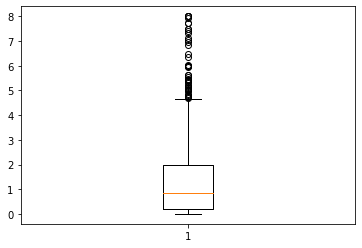

In [460]:
plt.boxplot(main_df['refactoring_perc_time_taken'])

(array([478.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 118.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

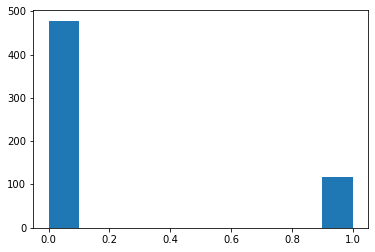

In [461]:
plt.hist(main_df['refactoring_perc_time_taken_bin'])

In [462]:
main_df['refactoring_perc_time_taken_bin'].value_counts()

0    478
1    118
Name: refactoring_perc_time_taken_bin, dtype: int64

In [463]:
main_df.dtypes

kmean_label                           int64
time_taken_mean                     float64
time_taken_min                      float64
time_taken_max                      float64
time_taken_q10                      float64
                                     ...   
geneticP_time_taken                 float64
softwareMaintenance_time_taken      float64
fuzzy_time_taken                    float64
time_taken_final                    float64
refactoring_perc_time_taken_bin    category
Length: 208, dtype: object

In [464]:
#main_df['refactoring_perc_time_taken_bin'] = main_df['refactoring_perc_time_taken_bin'].astype('string')

#main_df['refactoring_perc_time_taken_bin'] = main_df['refactoring_perc_time_taken_bin'].astype('category')

In [465]:
main_df.tail()

,kmean_label,time_taken_mean,time_taken_min,time_taken_max,time_taken_q10,time_taken_q20,time_taken_q25,time_taken_q30,time_taken_q40,time_taken_q50,...,actual_num_of_classes_touched_std,commit_line_changed,refactoring_perc,refactoring_perc_time_taken,cocomoII_time_taken,geneticP_time_taken,softwareMaintenance_time_taken,fuzzy_time_taken,time_taken_final,refactoring_perc_time_taken_bin
39,12,27.087805,1.0,165.0,1.0,2.0,2.0,3.0,5.6,15.0,...,0.000000,6803,0.010731,0.944289,3520.14432,2070.058368,44587.68,3766.348005,15.0,0
40,12,27.087805,1.0,165.0,1.0,2.0,2.0,3.0,5.6,15.0,...,0.000000,714,0.288515,6.347339,369.45216,220.749445,4643.84,841.170325,1.0,1
42,12,27.087805,1.0,165.0,1.0,2.0,2.0,3.0,5.6,15.0,...,16.743158,635,0.286614,7.738583,328.57440,196.365047,4125.60,778.070877,6.0,1
43,12,27.087805,1.0,165.0,1.0,2.0,2.0,3.0,5.6,15.0,...,1.964427,615,0.053659,0.053659,318.22560,190.190193,3994.40,761.687072,0.0,0
2,6,24.474860,1.0,167.0,1.0,2.0,4.0,5.0,10.0,16.0,...,2.946898,1696,0.004127,0.198113,877.57824,523.020584,11085.76,1495.349884,9.0,0


(array([292., 111.,  67.,  37.,  26.,  20.,  19.,   8.,   5.,  11.]),
 array([1.20827670e-04, 8.00108745e-01, 1.60009666e+00, 2.40008458e+00,
        3.20007250e+00, 4.00006041e+00, 4.80004833e+00, 5.60003625e+00,
        6.40002417e+00, 7.20001208e+00, 8.00000000e+00]),
 <a list of 10 Patch objects>)

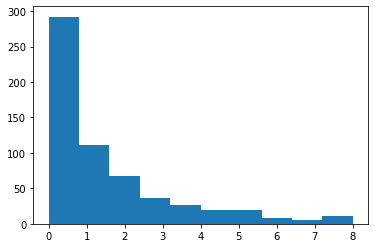

In [466]:
plt.hist(main_df['refactoring_perc_time_taken'])

(array([143.,  73.,  46.,  30.,  54.,  16.,  20.,  21.,  22.,  35.,   7.,
          3.,  12.,   3.,  15.,   7.,   5.,   5.,   4.,  12.,   7.,   5.,
          1.,   7.,   8.,   4.,   4.,   3.,   2.,   4.,   1.,   1.,   1.,
          0.,   2.,   2.,   1.,   3.,   2.,   5.]),
 array([1.20827670e-04, 2.00117807e-01, 4.00114786e-01, 6.00111766e-01,
        8.00108745e-01, 1.00010572e+00, 1.20010270e+00, 1.40009968e+00,
        1.60009666e+00, 1.80009364e+00, 2.00009062e+00, 2.20008760e+00,
        2.40008458e+00, 2.60008156e+00, 2.80007854e+00, 3.00007552e+00,
        3.20007250e+00, 3.40006948e+00, 3.60006646e+00, 3.80006343e+00,
        4.00006041e+00, 4.20005739e+00, 4.40005437e+00, 4.60005135e+00,
        4.80004833e+00, 5.00004531e+00, 5.20004229e+00, 5.40003927e+00,
        5.60003625e+00, 5.80003323e+00, 6.00003021e+00, 6.20002719e+00,
        6.40002417e+00, 6.60002114e+00, 6.80001812e+00, 7.00001510e+00,
        7.20001208e+00, 7.40000906e+00, 7.60000604e+00, 7.80000302e+00,
      

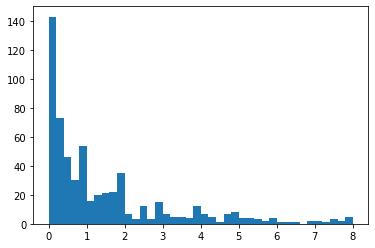

In [467]:
plt.hist(main_df['refactoring_perc_time_taken'],bins=40)

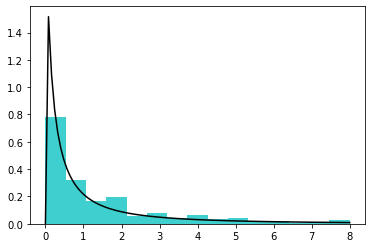

In [468]:
s, loc, scale = sp.stats.lognorm.fit(main_df['refactoring_perc_time_taken'], floc=0)
estimated_mu = np.log(scale)
estimated_sigma = s


plt.hist(main_df['refactoring_perc_time_taken'], bins=15, density=True, color='c', alpha=0.75)
xmin = main_df['refactoring_perc_time_taken'].min()
xmin = 0
xmax = main_df['refactoring_perc_time_taken'].max()
x = np.linspace(xmin, xmax, 100)
pdf = sp.stats.lognorm.pdf(x, s, scale=scale)
plt.plot(x, pdf, 'k')

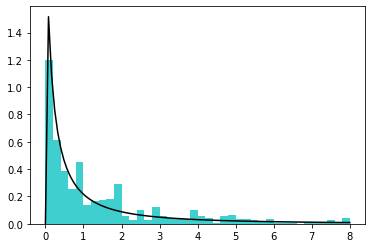

In [469]:
s, loc, scale = sp.stats.lognorm.fit(main_df['refactoring_perc_time_taken'], floc=0)
estimated_mu = np.log(scale)
estimated_sigma = s


plt.hist(main_df['refactoring_perc_time_taken'], bins=40, density=True, color='c', alpha=0.75)
xmin = main_df['refactoring_perc_time_taken'].min()
xmin = 0
xmax = main_df['refactoring_perc_time_taken'].max()
x = np.linspace(xmin, xmax, 100)
pdf = sp.stats.lognorm.pdf(x, s, scale=scale)
plt.plot(x, pdf, 'k')

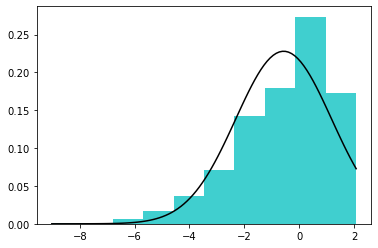

In [470]:
logdata = np.log(main_df['refactoring_perc_time_taken'])
plt.hist(logdata, bins=10, density=True, color='c', alpha=0.75)
xmin = logdata.min()
xmax = logdata.max()
x = np.linspace(xmin, xmax, 100)
pdf = sp.stats.norm.pdf(x, loc=estimated_mu, scale=estimated_sigma)
plt.plot(x, pdf, 'k')

In [471]:
len(main_df)

596

In [472]:
main_df.to_csv('test_effort_model.csv', index=False)

## EDA (Run only if absolutely necessary on minimum features)

In [473]:
#from pandas_profiling import ProfileReport

#profile = ProfileReport(main_df, title="Pandas Profiling Report",explorative=True)
#profile

In [474]:
for columns in main_df.columns:
    print(columns)

kmean_label
time_taken_mean
time_taken_min
time_taken_max
time_taken_q10
time_taken_q20
time_taken_q25
time_taken_q30
time_taken_q40
time_taken_q50
time_taken_q60
time_taken_q70
time_taken_q75
time_taken_q80
time_taken_q90
sha
name
email
date
login
message
parent_sha
parent_date
time_taken
contains_refactoring
project_name
commit_compared_with
cbo_mean
cbo_min
cbo_max
cbo_std
wmc_mean
wmc_min
wmc_max
wmc_std
dit_mean
dit_min
dit_max
dit_std
rfc_mean
rfc_min
rfc_max
rfc_std
lcom_mean
lcom_min
lcom_max
lcom_std
totalMethods_mean
totalMethods_min
totalMethods_max
totalMethods_std
staticMethods_mean
staticMethods_min
staticMethods_max
staticMethods_std
publicMethods_mean
publicMethods_min
publicMethods_max
publicMethods_std
privateMethods_mean
privateMethods_min
privateMethods_max
privateMethods_std
protectedMethods_mean
protectedMethods_min
protectedMethods_max
protectedMethods_std
defaultMethods_mean
defaultMethods_min
defaultMethods_max
defaultMethods_std
abstractMethods_mean
abstractMe

### Only taking mean for num_dependency and num_line_affected since there is only one

In [475]:
final_col = []
column_to_skip = ['sha',
'name','email','login',
'date','message',
'parent_sha','parent_date',
'time_taken','contains_refactoring',
'kmean_label','time_taken_mean',
'time_taken_min',
'time_taken_max',
'time_taken_q10',
'time_taken_q20',
'time_taken_q25',
'time_taken_q30',
'time_taken_q40',
'time_taken_q50',
'time_taken_q60',
'time_taken_q70',
'time_taken_q75',
'time_taken_q80',
'time_taken_q90',
'project_name','commit_compared_with',
'actual_num_of_classes_touched_mean',
 'actual_num_of_classes_touched_min',
 'actual_num_of_classes_touched_max',
 'actual_num_of_classes_touched_std',
'num_dependency_min',
'num_dependency_max',
'num_dependency_std',
'num_line_affected_min',
'num_line_affected_max',
'num_line_affected_std', 'time_taken_final',
'commit_line_changed',
'refactoring_perc',
 'cocomoII_time_taken',
'geneticP_time_taken',
'softwareMaintenance_time_taken',
'fuzzy_time_taken',
'time_taken_final',
'refactoring_perc_time_taken'
 ]
for element in main_df.columns:
    #print("'" + element + "',")
    if element not in column_to_skip:
        final_col.append(element)

In [476]:
final_col

['cbo_mean',
 'cbo_min',
 'cbo_max',
 'cbo_std',
 'wmc_mean',
 'wmc_min',
 'wmc_max',
 'wmc_std',
 'dit_mean',
 'dit_min',
 'dit_max',
 'dit_std',
 'rfc_mean',
 'rfc_min',
 'rfc_max',
 'rfc_std',
 'lcom_mean',
 'lcom_min',
 'lcom_max',
 'lcom_std',
 'totalMethods_mean',
 'totalMethods_min',
 'totalMethods_max',
 'totalMethods_std',
 'staticMethods_mean',
 'staticMethods_min',
 'staticMethods_max',
 'staticMethods_std',
 'publicMethods_mean',
 'publicMethods_min',
 'publicMethods_max',
 'publicMethods_std',
 'privateMethods_mean',
 'privateMethods_min',
 'privateMethods_max',
 'privateMethods_std',
 'protectedMethods_mean',
 'protectedMethods_min',
 'protectedMethods_max',
 'protectedMethods_std',
 'defaultMethods_mean',
 'defaultMethods_min',
 'defaultMethods_max',
 'defaultMethods_std',
 'abstractMethods_mean',
 'abstractMethods_min',
 'abstractMethods_max',
 'abstractMethods_std',
 'finalMethods_mean',
 'finalMethods_min',
 'finalMethods_max',
 'finalMethods_std',
 'synchronizedMetho

In [477]:
X_col = final_col.copy()
X_col.remove('refactoring_perc_time_taken_bin')
Y_col = ['refactoring_perc_time_taken_bin']

X = main_df[X_col]
y = main_df[Y_col]
final_df = main_df[final_col]

In [478]:
X.head()

,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,...,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean
1,12.000000,12.0,12.0,0.000000,8.000000,8.0,8.0,0.000000,1.000000,1.0,...,68.000000,68.0,68.0,0.000000,17.000000,17.0,17.0,0.000000,3.000000,78.000000
2,30.000000,30.0,30.0,0.000000,29.000000,29.0,29.0,0.000000,1.000000,1.0,...,103.000000,103.0,103.0,0.000000,1.000000,1.0,1.0,0.000000,78.000000,322.000000
3,23.250000,5.0,63.0,20.780782,20.666667,4.0,64.0,21.993112,2.000000,1.0,...,121.333333,37.0,320.0,98.919006,1.000000,1.0,1.0,0.000000,57.583333,222.666667
4,7.833333,0.0,31.0,11.027514,7.833333,1.0,21.0,7.444746,1.166667,1.0,...,63.500000,8.0,125.0,36.335557,10.333333,1.0,17.0,8.238858,54.333333,88.000000
5,25.000000,25.0,25.0,0.000000,32.000000,32.0,32.0,0.000000,1.000000,1.0,...,166.000000,166.0,166.0,0.000000,1025.000000,1025.0,1025.0,0.000000,51.000000,321.000000


In [479]:
y.head()

,refactoring_perc_time_taken_bin
1,0
2,0
3,1
4,0
5,0


## Feature Engineering

In [480]:
h2o.init(nthreads=4)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,5 hours 25 mins
H2O_cluster_timezone:,Asia/Kuala_Lumpur
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.7
H2O_cluster_version_age:,5 months and 16 days !!!
H2O_cluster_name:,H2O_from_python_tanji_zhd7iz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.657 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [481]:
important_var = ['cbo_std',
 'uniqueWordsQty_min',
 'rfc_std',
 'totalMethods_min',
 'uniqueWordsQty_mean',
 'num_dependency_mean',
 'loc_min',
 'num_line_affected_mean',
 'uniqueWordsQty_max',
 'assignmentsQty_min',
 'loc_mean',
 'rfc_max',
 'cbo_mean',
 'rfc_mean',
 'lambdasQty_mean',
 'variablesQty_std',
 'maxNestedBlocks_mean',
 'numbersQty_mean',
 'stringLiteralsQty_min',
 'cbo_max']

In [482]:
from h2o.automl import H2OAutoML

full = h2o.H2OFrame(final_df)
full['refactoring_perc_time_taken_bin'] = full['refactoring_perc_time_taken_bin'].asfactor()
train,test = full.split_frame(ratios=[0.7], seed=16)


#x = train.columns
x = important_var
y = "refactoring_perc_time_taken_bin"
#x.remove(y)



Parse progress: |█████████████████████████████████████████████████████████| 100%


In [483]:
full.shape

(596, 163)

In [484]:
train[x].types

{'cbo_std': 'real',
 'uniqueWordsQty_min': 'int',
 'rfc_std': 'real',
 'totalMethods_min': 'int',
 'uniqueWordsQty_mean': 'real',
 'num_dependency_mean': 'real',
 'loc_min': 'int',
 'num_line_affected_mean': 'real',
 'uniqueWordsQty_max': 'int',
 'assignmentsQty_min': 'int',
 'loc_mean': 'real',
 'rfc_max': 'int',
 'cbo_mean': 'real',
 'rfc_mean': 'real',
 'lambdasQty_mean': 'real',
 'variablesQty_std': 'real',
 'maxNestedBlocks_mean': 'real',
 'numbersQty_mean': 'real',
 'stringLiteralsQty_min': 'int',
 'cbo_max': 'int'}

In [485]:
train[y].types

{'refactoring_perc_time_taken_bin': 'enum'}

In [486]:
aml = H2OAutoML(max_models=25, seed=16, balance_classes=True)
#aml = H2OAutoML(max_models=25, seed=16, balance_classes=True)
#aml = H2OAutoML(max_models=10, seed=1, include_algos=['GLM'])
aml.train(x=important_var, y=y, training_frame=train)

AutoML progress: |█
08:27:13.340: AutoML: XGBoost is not available; skipping it.

█████████████████████████████████████████████████████Failed polling AutoML progress log: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\tanji\\AppData\\Local\\Temp\\tmpr0pi1687.csv'
██| 100%


In [487]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_grid__1_AutoML_20220219_082713_model_6,0.68951,0.514365,0.443485,0.362434,0.398596,0.158879
GBM_grid__1_AutoML_20220219_082713_model_2,0.683574,0.503877,0.436911,0.361942,0.396848,0.157488
DRF_1_AutoML_20220219_082713,0.680708,0.539132,0.395369,0.366758,0.408606,0.166959
StackedEnsemble_BestOfFamily_AutoML_20220219_082713,0.677791,0.48098,0.418689,0.36742,0.393262,0.154655
GBM_grid__1_AutoML_20220219_082713_model_5,0.677096,0.559686,0.393972,0.375322,0.409415,0.167621
DeepLearning_grid__3_AutoML_20220219_082713_model_2,0.673586,0.514132,0.390474,0.355345,0.40407,0.163272
XRT_1_AutoML_20220219_082713,0.672483,0.553817,0.412082,0.372914,0.407805,0.166305
GBM_grid__1_AutoML_20220219_082713_model_1,0.672059,0.522825,0.409005,0.357991,0.402409,0.161933
GBM_5_AutoML_20220219_082713,0.658018,0.498425,0.356743,0.378222,0.402202,0.161766
GBM_grid__1_AutoML_20220219_082713_model_3,0.656475,0.497624,0.379884,0.36335,0.401328,0.161064


In [488]:
model = h2o.get_model(lb[0,'model_id'])

In [489]:
model

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid__1_AutoML_20220219_082713_model_6


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,31.0,31.0,15176.0,8.0,14.0,11.193548,28.0,39.0,34.032257




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.11084184240415328
RMSE: 0.33292918526941023
LogLoss: 0.3457684410356626
Mean Per-Class Error: 0.007716049382715973
AUC: 0.9973310443168599
AUCPR: 0.9965959044827027
Gini: 0.9946620886337199

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26095788606321546: 


,,0,1,Error,Rate
0,0,319.0,5.0,0.0154,(5.0/324.0)
1,1,0.0,329.0,0.0,(0.0/329.0)
2,Total,319.0,334.0,0.0077,(5.0/653.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.260958,0.992459,92.0
1,max f2,0.260958,0.996970,92.0
2,max f0point5,0.309735,0.990130,87.0
3,max accuracy,0.260958,0.992343,92.0
4,max precision,0.780641,1.000000,0.0
5,max recall,0.260958,1.000000,92.0
6,max specificity,0.780641,1.000000,0.0
7,max absolute_mcc,0.260958,0.984799,92.0
8,max min_per_class_accuracy,0.263241,0.984568,91.0
9,max mean_per_class_accuracy,0.260958,0.992284,92.0



Gains/Lift Table: Avg response rate: 50.38 %, avg score: 31.44 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.012251,0.770225,1.984802,1.984802,1.000000,0.775433,1.000000,0.775433,0.024316,0.024316,98.480243,98.480243,0.024316
1,2,0.022971,0.755085,1.984802,1.984802,1.000000,0.755213,1.000000,0.765997,0.021277,0.045593,98.480243,98.480243,0.045593
2,3,0.033691,0.732997,1.984802,1.984802,1.000000,0.740647,1.000000,0.757931,0.021277,0.066869,98.480243,98.480243,0.066869
3,4,0.042879,0.721979,1.984802,1.984802,1.000000,0.723377,1.000000,0.750527,0.018237,0.085106,98.480243,98.480243,0.085106
4,5,0.052067,0.715672,1.984802,1.984802,1.000000,0.715672,1.000000,0.744376,0.018237,0.103343,98.480243,98.480243,0.103343
5,6,0.101072,0.665235,1.984802,1.984802,1.000000,0.678792,1.000000,0.712578,0.097264,0.200608,98.480243,98.480243,0.200608
6,7,0.150077,0.620094,1.984802,1.984802,1.000000,0.646571,1.000000,0.691024,0.097264,0.297872,98.480243,98.480243,0.297872
7,8,0.203675,0.605616,1.984802,1.984802,1.000000,0.613892,1.000000,0.670726,0.106383,0.404255,98.480243,98.480243,0.404255
8,9,0.303216,0.516895,1.954267,1.974778,0.984615,0.561460,0.994949,0.634856,0.194529,0.598784,95.426701,97.477818,0.595698
9,10,0.399694,0.468220,1.953298,1.969593,0.984127,0.491248,0.992337,0.600192,0.188450,0.787234,95.329763,96.959322,0.781061




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.15887864501837032
RMSE: 0.39859584169728907
LogLoss: 0.5143650175749989
Mean Per-Class Error: 0.36243386243386244
AUC: 0.6895095645095645
AUCPR: 0.44348511454808165
Gini: 0.37901912901912893

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.13485005023329966: 


,,0,1,Error,Rate
0,0,228.0,96.0,0.2963,(96.0/324.0)
1,1,39.0,52.0,0.4286,(39.0/91.0)
2,Total,267.0,148.0,0.3253,(135.0/415.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.134850,0.435146,147.0
1,max f2,0.036688,0.609929,330.0
2,max f0point5,0.470940,0.471698,16.0
3,max accuracy,0.490003,0.812048,14.0
4,max precision,0.490003,0.933333,14.0
5,max recall,0.016230,1.000000,385.0
6,max specificity,0.778836,0.996914,0.0
7,max absolute_mcc,0.490003,0.334197,14.0
8,max min_per_class_accuracy,0.111851,0.617284,177.0
9,max mean_per_class_accuracy,0.134850,0.637566,147.0



Gains/Lift Table: Avg response rate: 21.93 %, avg score: 13.81 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.012048,0.593988,3.648352,3.648352,0.800000,0.707981,0.800000,0.707981,0.043956,0.043956,264.835165,264.835165,0.040870
1,2,0.021687,0.533488,4.560440,4.053724,1.000000,0.563584,0.888889,0.643804,0.043956,0.087912,356.043956,305.372405,0.084826
2,3,0.031325,0.502051,4.560440,4.209637,1.000000,0.517217,0.923077,0.604855,0.043956,0.131868,356.043956,320.963652,0.128782
3,4,0.040964,0.463416,3.420330,4.023917,0.750000,0.483840,0.882353,0.576381,0.032967,0.164835,242.032967,302.391726,0.158662
4,5,0.050602,0.425217,0.000000,3.257457,0.000000,0.444811,0.714286,0.551320,0.000000,0.164835,-100.000000,225.745683,0.146317
5,6,0.101205,0.308853,1.954474,2.605965,0.428571,0.363554,0.571429,0.457437,0.098901,0.263736,95.447410,160.596546,0.208181
6,7,0.151807,0.248144,1.302983,2.171638,0.285714,0.274166,0.476190,0.396346,0.065934,0.329670,30.298273,117.163789,0.227818
7,8,0.200000,0.209645,1.368132,1.978022,0.300000,0.224332,0.433735,0.354897,0.065934,0.395604,36.813187,97.802198,0.250543
8,9,0.301205,0.154912,0.977237,1.641758,0.214286,0.179648,0.360000,0.296013,0.098901,0.494505,-2.276295,64.175824,0.247592
9,10,0.400000,0.120633,0.778612,1.428571,0.170732,0.138123,0.313253,0.257016,0.076923,0.571429,-22.138837,42.857143,0.219577




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.6939759,0.17739916,0.8915663,0.6987952,0.48192772,0.8433735,0.55421686
1,auc,0.7015853,0.07113408,0.76212686,0.6478261,0.64215684,0.7941176,0.66169894
2,err,0.3060241,0.17739916,0.10843374,0.30120483,0.5180723,0.15662651,0.44578314
3,err_count,25.4,14.72413,9.0,25.0,43.0,13.0,37.0
4,f0point5,0.49963427,0.17214225,0.75,0.47244096,0.29288703,0.56962025,0.41322315
5,f1,0.5301909,0.10169327,0.6666667,0.48979592,0.3943662,0.58064514,0.5194805
6,f2,0.60066575,0.06765636,0.6,0.5084746,0.6034483,0.59210527,0.6993007
7,lift_top_group,3.6204512,2.193499,5.1875,3.6086957,0.0,5.5333333,3.7727273
8,logloss,0.514365,0.12261055,0.40058804,0.6691731,0.48929942,0.4003943,0.6123702
9,max_per_class_error,0.5014357,0.091721654,0.4375,0.47826087,0.61764705,0.4,0.57377046



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2022-02-19 08:27:24,1.643 sec,0.0,0.575287,0.887339,0.500000,0.503828,1.000000,0.496172
1,,2022-02-19 08:27:24,1.657 sec,5.0,0.521143,0.726693,0.959318,0.949107,1.984802,0.091884
2,,2022-02-19 08:27:24,1.668 sec,10.0,0.475999,0.615823,0.979863,0.969697,1.984802,0.062787
3,,2022-02-19 08:27:24,1.678 sec,15.0,0.435580,0.527610,0.990286,0.980802,1.984802,0.022971
4,,2022-02-19 08:27:24,1.688 sec,20.0,0.404547,0.467345,0.992978,0.989481,1.984802,0.021440
5,,2022-02-19 08:27:24,1.699 sec,25.0,0.370467,0.406914,0.995197,0.992415,1.984802,0.016845
6,,2022-02-19 08:27:24,1.709 sec,30.0,0.338774,0.355122,0.996853,0.995785,1.984802,0.007657
7,,2022-02-19 08:27:24,1.713 sec,31.0,0.332929,0.345768,0.997331,0.996596,1.984802,0.007657



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,num_line_affected_mean,56.580254,1.000000,0.097140
1,rfc_mean,52.614704,0.929913,0.090332
2,totalMethods_min,38.571651,0.681716,0.066222
3,cbo_std,36.996113,0.653870,0.063517
4,uniqueWordsQty_max,36.802341,0.650445,0.063185
5,uniqueWordsQty_mean,35.583611,0.628905,0.061092
6,uniqueWordsQty_min,34.766205,0.614458,0.059689
7,rfc_max,33.515022,0.592345,0.057541
8,cbo_mean,29.132755,0.514893,0.050017
9,loc_mean,29.057621,0.513565,0.049888


In [490]:
variable_importance=  model.varimp(use_pandas=True)
variable_importance

,variable,relative_importance,scaled_importance,percentage
0,num_line_affected_mean,56.580254,1.000000,0.097140
1,rfc_mean,52.614704,0.929913,0.090332
2,totalMethods_min,38.571651,0.681716,0.066222
3,cbo_std,36.996113,0.653870,0.063517
4,uniqueWordsQty_max,36.802341,0.650445,0.063185
5,uniqueWordsQty_mean,35.583611,0.628905,0.061092
6,uniqueWordsQty_min,34.766205,0.614458,0.059689
7,rfc_max,33.515022,0.592345,0.057541
8,cbo_mean,29.132755,0.514893,0.050017
9,loc_mean,29.057621,0.513565,0.049888


In [491]:
important_var = []
for element in variable_importance['variable'].head(20):
    important_var.append(element)

In [492]:
important_var

['num_line_affected_mean',
 'rfc_mean',
 'totalMethods_min',
 'cbo_std',
 'uniqueWordsQty_max',
 'uniqueWordsQty_mean',
 'uniqueWordsQty_min',
 'rfc_max',
 'cbo_mean',
 'loc_mean',
 'num_dependency_mean',
 'assignmentsQty_min',
 'loc_min',
 'maxNestedBlocks_mean',
 'stringLiteralsQty_min',
 'lambdasQty_mean',
 'variablesQty_std',
 'numbersQty_mean',
 'cbo_max',
 'rfc_std']

In [493]:
preds = model.predict(test[x])

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [494]:
preds

predict,p0,p1
1,0.718575,0.281425
0,0.848835,0.151165
1,0.72343,0.27657
0,0.912333,0.0876666
0,0.908988,0.0910119
0,0.914744,0.0852561
0,0.782397,0.217603
0,0.940808,0.0591918
0,0.984056,0.0159445
0,0.989575,0.010425


In [495]:
pd_preds = preds.as_data_frame()
pd_preds['predict'].value_counts()

0    154
1     27
Name: predict, dtype: int64

In [496]:
test.head()

cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,dit_max,dit_std,rfc_mean,rfc_min,rfc_max,rfc_std,lcom_mean,lcom_min,lcom_max,lcom_std,totalMethods_mean,totalMethods_min,totalMethods_max,totalMethods_std,staticMethods_mean,staticMethods_min,staticMethods_max,staticMethods_std,publicMethods_mean,publicMethods_min,publicMethods_max,publicMethods_std,privateMethods_mean,privateMethods_min,privateMethods_max,privateMethods_std,protectedMethods_mean,protectedMethods_min,protectedMethods_max,protectedMethods_std,defaultMethods_mean,defaultMethods_min,defaultMethods_max,defaultMethods_std,abstractMethods_mean,abstractMethods_min,abstractMethods_max,abstractMethods_std,finalMethods_mean,finalMethods_min,finalMethods_max,finalMethods_std,synchronizedMethods_mean,synchronizedMethods_min,synchronizedMethods_max,synchronizedMethods_std,totalFields_mean,totalFields_min,totalFields_max,totalFields_std,staticFields_mean,staticFields_min,staticFields_max,staticFields_std,publicFields_mean,publicFields_min,publicFields_max,publicFields_std,privateFields_mean,privateFields_min,privateFields_max,privateFields_std,protectedFields_mean,protectedFields_min,protectedFields_max,protectedFields_std,defaultFields_mean,defaultFields_min,defaultFields_max,defaultFields_std,finalFields_mean,finalFields_min,finalFields_max,finalFields_std,synchronizedFields_mean,synchronizedFields_min,synchronizedFields_max,synchronizedFields_std,nosi_mean,nosi_min,nosi_max,nosi_std,loc_mean,loc_min,loc_max,loc_std,returnQty_mean,returnQty_min,returnQty_max,returnQty_std,loopQty_mean,loopQty_min,loopQty_max,loopQty_std,comparisonsQty_mean,comparisonsQty_min,comparisonsQty_max,comparisonsQty_std,tryCatchQty_mean,tryCatchQty_min,tryCatchQty_max,tryCatchQty_std,parenthesizedExpsQty_mean,parenthesizedExpsQty_min,parenthesizedExpsQty_max,parenthesizedExpsQty_std,stringLiteralsQty_mean,stringLiteralsQty_min,stringLiteralsQty_max,stringLiteralsQty_std,numbersQty_mean,numbersQty_min,numbersQty_max,numbersQty_std,assignmentsQty_mean,assignmentsQty_min,assignmentsQty_max,assignmentsQty_std,mathOperationsQty_mean,mathOperationsQty_min,mathOperationsQty_max,mathOperationsQty_std,variablesQty_mean,variablesQty_min,variablesQty_max,variablesQty_std,maxNestedBlocks_mean,maxNestedBlocks_min,maxNestedBlocks_max,maxNestedBlocks_std,anonymousClassesQty_mean,anonymousClassesQty_min,anonymousClassesQty_max,anonymousClassesQty_std,subClassesQty_mean,subClassesQty_min,subClassesQty_max,subClassesQty_std,lambdasQty_mean,lambdasQty_min,lambdasQty_max,lambdasQty_std,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean,refactoring_perc_time_taken_bin
8,8,8,0,8,8,8,0,1,1,1,0,4,4,4,0,15,15,15,0,6,6,6,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,28,28,28,0,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,0,0,0,0,0,2,2,2,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,50,50,50,0,1,1,1,0,642,48,0
4,4,4,0,9,9,9,0,1,1,1,0,6,6,6,0,0,0,0,0,7,7,7,0,1,1,1,0,7,7,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,3,3,3,0,35,35,35,0,8,8,8,0,0,0,0,0,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,2,2,2,0,0,0,0,0,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,16,16,0,17,17,17,0,393,38,0
11.5,11,13,0.755929,4.75,4,6,0.707107,3.5,2,4,0.92582,12.75,11,20,2.96407,8.875,6,13,2.58775,4.75,4,6,0.707107,0,0,0,0,3.5,2,5,0.92582,0,0,0,0,1.25,0,2,0.886405,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.125,0,1,0.353553,0,0,0,0,0,0,0,0,0.125,0,1,0.353553,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,2,6,1.69031,42,36,56,6.39196,0.75,0,1,0.46291,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.75,2,3,0.46291,0.25,0,1,0.46291,4.125,2,5,0.991031,0,0,0,0,4.125,2,5,0.991031,0,0,0,0,0,0,0,0,0,0,0,0,2.75,2,3,0.46291,66.375,60,87,9.28805,1,1,1,0,21.875,59,1
13,12,14,1.09545,2.5

In [497]:
print(len(test))
print(len(pd_preds))

181
181


In [498]:
pd_test = test.as_data_frame()
pd_preds['actual_time_taken'] = pd_test['refactoring_perc_time_taken_bin']

In [499]:
pd_preds.head()

,predict,p0,p1,actual_time_taken
0,1,0.718575,0.281425,0
1,0,0.848835,0.151165,0
2,1,0.723430,0.276570,1
3,0,0.912333,0.087667,0
4,0,0.908988,0.091012,0


In [500]:
pd_preds.loc[(pd_preds.predict < 0),'predict']=1

In [501]:
pd_preds

,predict,p0,p1,actual_time_taken
0,1,0.718575,0.281425,0
1,0,0.848835,0.151165,0
2,1,0.723430,0.276570,1
3,0,0.912333,0.087667,0
4,0,0.908988,0.091012,0
...,...,...,...,...
176,0,0.905047,0.094953,0
177,0,0.802386,0.197614,0
178,0,0.961983,0.038017,0
179,0,0.843222,0.156778,0



Testing Results of the trained model: 

Accuracy :  0.8121546961325967

Confusion Matrix :
 [[137  17]
 [ 17  10]]

Classification Report :
               precision    recall  f1-score   support

           0       0.89      0.89      0.89       154
           1       0.37      0.37      0.37        27

    accuracy                           0.81       181
   macro avg       0.63      0.63      0.63       181
weighted avg       0.81      0.81      0.81       181



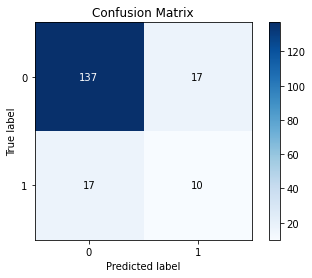

In [502]:
# For Classification
import scikitplot as skplt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import cohen_kappa_score, confusion_matrix

# Predict with the best model.
#predicted_y = model.predict(valid[featureColumns])

#predicted_data = predicted_y.as_data_frame()
#valid_dataset = valid.as_data_frame()

# Evaluate the skill of the Trained model
acc = accuracy_score(pd_preds['actual_time_taken'], pd_preds['predict'])
classReport = classification_report(pd_preds['actual_time_taken'], pd_preds['predict'])
confMatrix  = confusion_matrix(pd_preds['actual_time_taken'], pd_preds['predict']) 
        
print(); print('Testing Results of the trained model: ')
print(); print('Accuracy : ', acc)
print(); print('Confusion Matrix :\n', confMatrix)
print(); print('Classification Report :\n',classReport)

# Confusion matrix
skplt.metrics.plot_confusion_matrix(pd_preds['actual_time_taken'], pd_preds['predict'])

In [198]:
visualization = pd_preds[pd_preds['predict'] <= 20]
visualization = pd_preds[pd_preds['actual_time_taken'] <= 20]


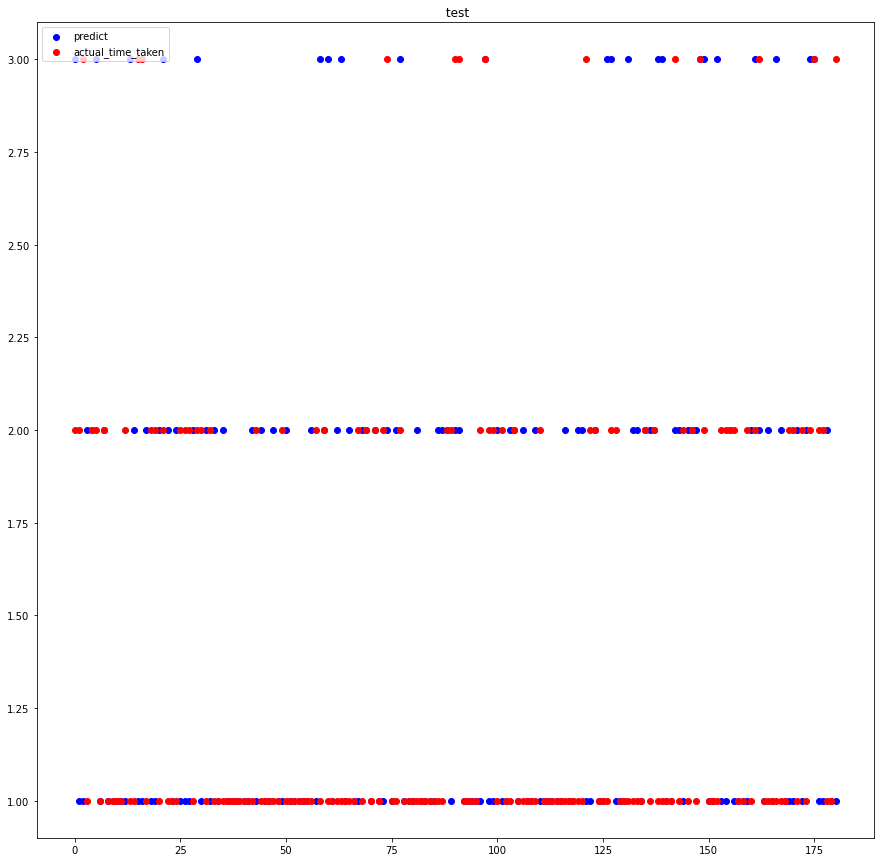

In [199]:
plotGraph(visualization['predict'], visualization['actual_time_taken'],'predict','actual_time_taken',' test')

In [503]:
# save the model
model_path = h2o.save_model(model=model, path="models/EffortEstimationModelv2Classification", force=True)

Documentation at the following

https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/_modules/h2o/explanation/_explain.html

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

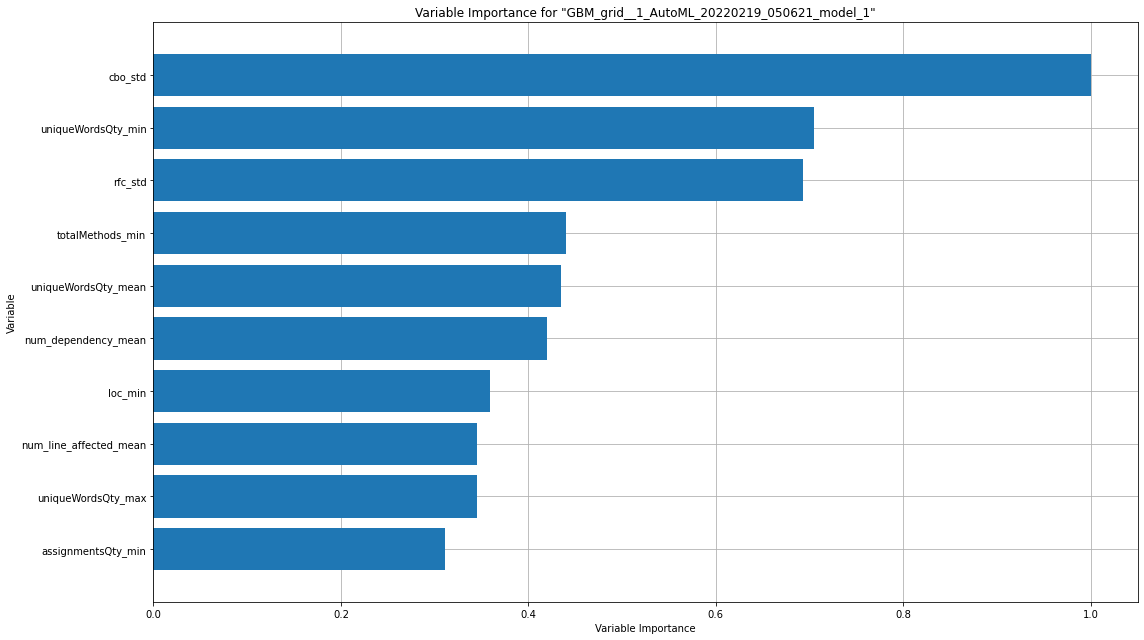

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

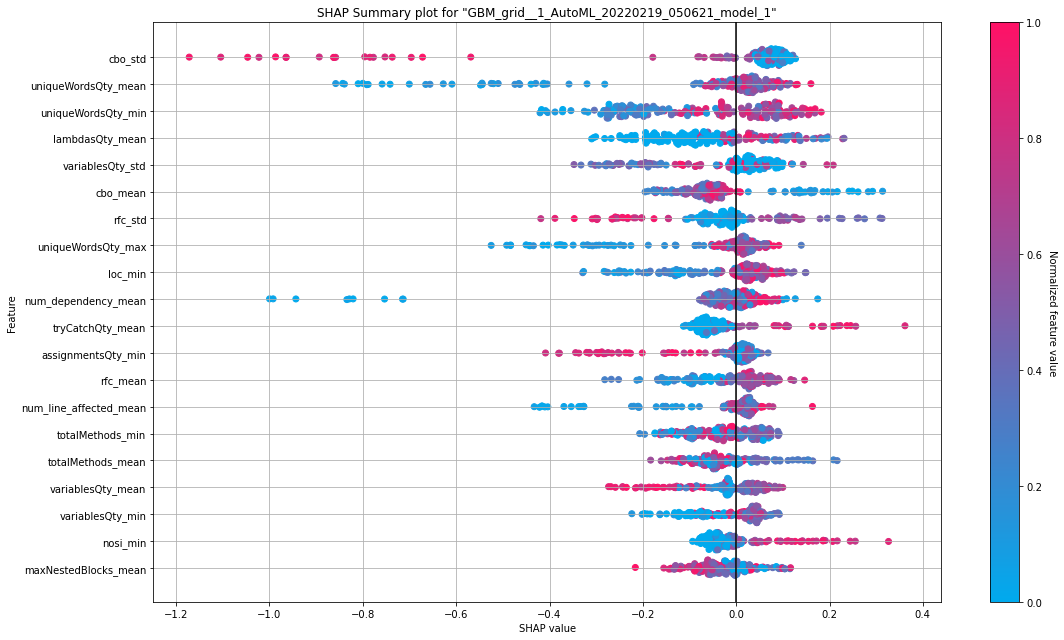

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

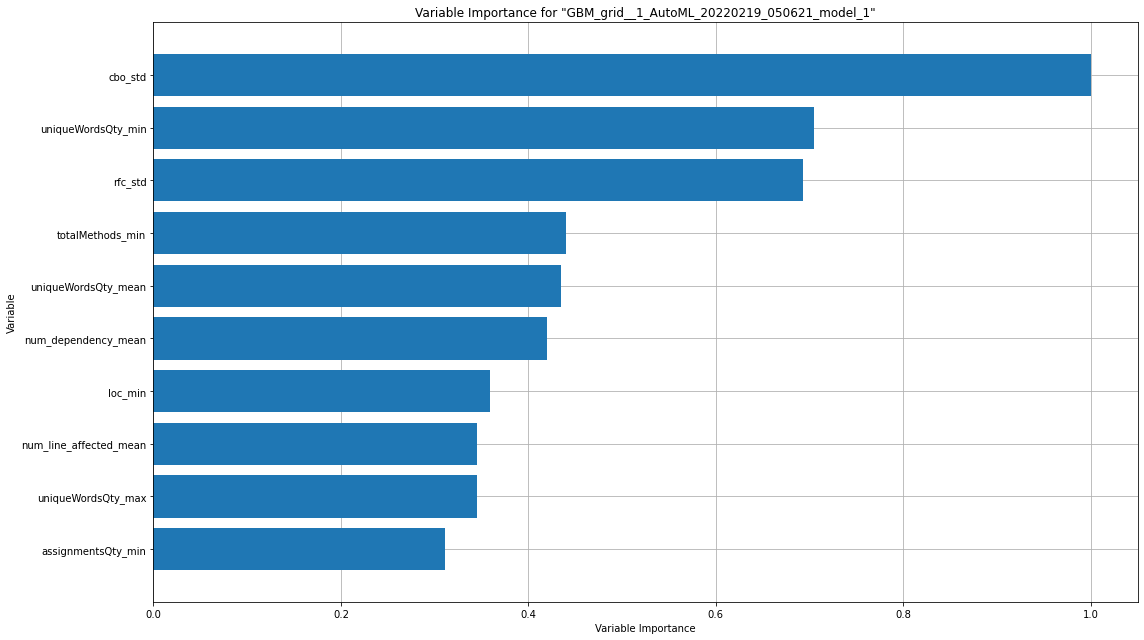

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

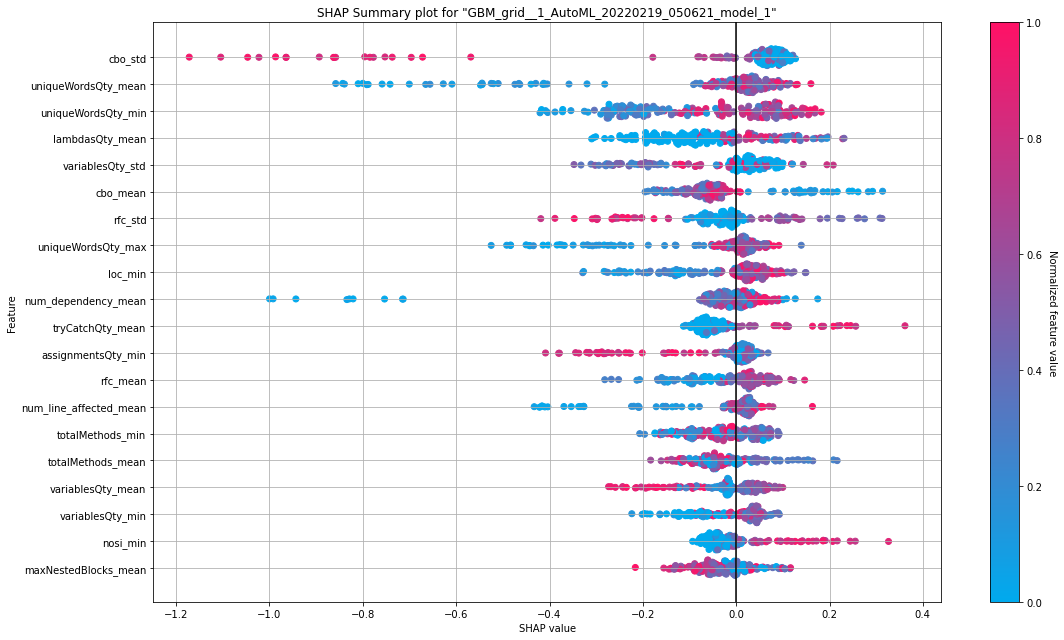

In [134]:
aml.explain(test, include_explanations=["varimp",'shap_summary'])

In [40]:
## Test calling of model

model_path = "models/EffortEstimationModelv2/SmallWithinADay_23_DeepLearning_grid__3_AutoML_20220213_032636_model_2"
saved_model = h2o.load_model(model_path)

In [41]:
preds_read_model = saved_model.predict(test)
pd_preds_read_model = preds_read_model.as_data_frame()
pd_test = test.as_data_frame()
#pd_preds = preds.as_data_frame()
pd_preds_read_model['actual_time_taken'] = pd_test['refactoring_perc_time_taken']

deeplearning prediction progress: |███████████████████████████████████████| 100%


In [42]:
pd_preds_read_model.head()

,predict,actual_time_taken
0,0.395690,1.097143
1,0.156619,1.628571
2,2.908174,7.411236
3,3.828710,0.268657
4,1.830154,3.480952


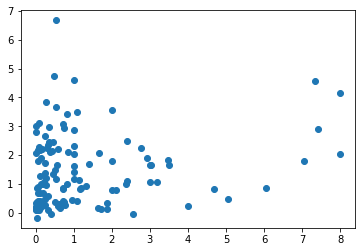

In [43]:
import matplotlib.pyplot as plt
plt.scatter(pd_preds_read_model['actual_time_taken'], pd_preds_read_model['predict'])

In [ ]:
plotGraph(pd_preds_read_model['predict'], pd_preds_read_model['actual_time_taken'],'predict','actual_time_taken',' test')

In [ ]:
#aml.explain_row(test, row_index=0)

In [ ]:
#h2o.shutdown()